In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Data Augmentation-XrayImg

Mounted at /content/gdrive
/content/gdrive/MyDrive/Data Augmentation-XrayImg


In [ ]:
#!unzip ./original.zip    # data

# 0. Import Libraries

In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset
import os
import glob
import cv2
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

from matplotlib import patches
import numpy as np 

# 1. Configs

In [ ]:
data_train_path = './original/dataDetect_train'
data_test_path = './original/dataDetect_test'
train_data_json='./train_data.json'
test_data_json='./test_data.json'
device='cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE=4 # CUDA out of memory :(
EPOCH_N=100
CLASS_N=2
WIDTH=512
HEIGHT=512

# 2. Utils

In [ ]:
def get_anno(txt_path):
    annos=[]
    with open(txt_path) as f:
      for line in f.readlines():
        anno=line[:-1].split(" ")
        anno = [float(num) for num in anno]
        annos.append(anno[1:])
    return annos



def get_offset(annos,image): # for single image
  new_annos=[]
  for annotation in annos:
    bbox = [annotation[0] * image.shape[1], annotation[1] * image.shape[0], 
            annotation[2] * image.shape[1], annotation[3] * image.shape[0]]
    new_annos.append(bbox)
  return new_annos


def get_path(data_path):
  img_paths = glob.glob(os.path.join(data_path,"*.png"))
  dic={}
  for img_path in img_paths:
    txt_path = img_path.replace('.png','.txt')
    dic[img_path]=get_anno(txt_path)
  return dic


def my_draw(img_path,anno):
  image=cv2.imread(img_path)
  print(image.shape)
  bboxs=get_offset(anno,image)
  for bbox in bboxs:
    cv2.rectangle(image, (int(bbox[0] - bbox[2] / 2), int(bbox[1] - bbox[3] / 2)), (int(bbox[0] + bbox[2] / 2), int(bbox[1] + bbox[3] / 2)), (225, 0, 0), 2)
  plt.figure(figsize = (10, 10))
  plt.imshow(image)
  plt.show()


def read_json(path):
  with open(path,'r') as f:
    data = json.load(f)
  return data

def write_json(dic,path):
  with open(path,'w') as f:
    json.dump(dic,f,indent=4)



In [ ]:

dic_train=get_path(data_train_path)
dic_test=get_path(data_test_path)
write_json(dic_train,train_data_json)
write_json(dic_test,test_data_json)



('./original/dataDetect_test/finger_3688_image1.png', [[0.621118, 0.363281, 0.248447, 0.105469]])
(512, 161, 3)


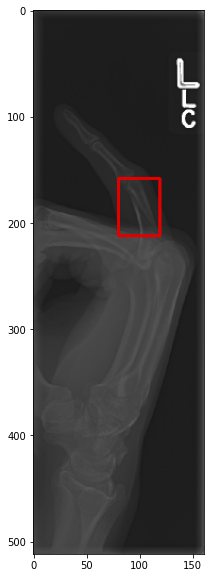

In [ ]:
# test one sample
test_dic=read_json(test_data_json)
item=next(iter(test_dic.items()))
print(item)
my_draw(item[0],item[1])

# 3. Dataset

In [ ]:

from torchvision import transforms


class XrayImgDataset(Dataset):
  def __init__(self,json_file,phase):
    self.data=read_json(json_file)
    self.img_paths=list(self.data.keys())
    self.bbxs=list(self.data.values())
    self.phase=phase
    self.transforms=torchvision.transforms.ToTensor()

  def convert_offsets(self,bbx,img):
    bboxs=get_offset(bbx,img)
    new_bbx=[[int(bbox[0] - bbox[2] / 2), int(bbox[1] - bbox[3] / 2),int(bbox[0] + bbox[2] / 2),int(bbox[1] + bbox[3] / 2)] for bbox in bboxs]
    return new_bbx

    
  def __getitem__(self,idx):
    img_path=self.img_paths[idx]
    img=cv2.imread(img_path)
    bbxs=self.convert_offsets(self.bbxs[idx],img)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB
    for bbx in bbxs:
      bbx[0]=bbx[0]/img.shape[1]*WIDTH
      bbx[1]=bbx[1]/img.shape[0]*HEIGHT
      bbx[2]=bbx[2]/img.shape[1]*WIDTH
      bbx[3]=bbx[3]/img.shape[0]*HEIGHT
    img=cv2.resize(img,(WIDTH,HEIGHT))
    img=img.astype(float)
    img=self.transforms(img)
    img=img/255
    bbxs=torch.FloatTensor(bbxs)


    targets={}
    targets['boxes']=bbxs
    targets['labels']=torch.ones(bbxs.shape[0]).long()
    return img,targets

  def __len__(self):
    return len(self.data)



In [ ]:
train_data=XrayImgDataset(train_data_json,'train')
train_dataloader = torch.utils.data.DataLoader(
   train_data,
   batch_size=BATCH_SIZE,
   num_workers=2,
   shuffle=True,
   collate_fn=lambda x: list(zip(*x)),
   )


val_data=XrayImgDataset(test_data_json,'val')
val_dataloader = torch.utils.data.DataLoader(
   val_data,
   batch_size=2,
   num_workers=2,
   shuffle=True,
   collate_fn=lambda x: list(zip(*x)),
   )



In [ ]:
# test one
item=iter(train_dataloader).next()
print(item[0])

# 4. Model 

In [ ]:
model=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features=model.roi_heads.box_predictor.cls_score.in_features
print(in_features)
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,CLASS_N)
model=model.to(device)
params=[p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=5e-4)
print(list(model.children()))

1024
[GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
), BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=0.0)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2

In [ ]:
model.load_state_dict(torch.load("./best_best_val.pth"))
best_point=9999
for epoch in range(EPOCH_N):
	print("Training...")
	train_loss=0
	val_loss=0
	for imgs,targets in tqdm(train_dataloader):
		model.train()
		model=model.double()
		optimizer.zero_grad()
		imgs=list(img.to(device) for img in imgs)
		targets=[{k:v.to(device) for k,v in t.items()} for t in targets]
		loss_dict=model(imgs,targets)
		losses=sum(loss for loss in loss_dict.values())   	
		losses.backward()
		optimizer.step()

		train_loss+=losses.item()

	for imgs,targets in tqdm(val_dataloader):
		model.eval()
		imgs=list(img.to(device) for img in imgs)
		targets=[{k:v.to(device) for k,v in t.items()} for t in targets]
		loss_dict_val=model(imgs,targets)
		losses_val=sum(loss for loss in loss_dict.values())
		val_loss+=losses_val.item()
		if losses_val.item()<best_point:
			best_point=losses_val.item()
			torch.save(model.state_dict(), "./best_best_val.pth")

		#print(losses.item())

	print("------------------------->", train_loss,val_loss)

# 5. Predict

In [ ]:
model.load_state_dict(torch.load( "./best_best_val.pth"))

<All keys matched successfully>

In [ ]:
item=iter(val_dataloader)
images,targets=item.next()

In [ ]:
def view(images,labels,k,std=1,mean=0):
  figure=plt.figure(figsize=(30,30))
  images=list(images)
  labels=list(labels)
  for i in range(k):
    out=torchvision.utils.make_grid(images[i])
    inp=out.cpu().numpy().transpose((1,2,0))
    inp=np.array(std)*inp+np.array(mean)
    inp=np.clip(inp,0,1)  
    ax = figure.add_subplot(2,2, i + 1)
    ax.imshow(images[i].cpu().numpy().transpose((1,2,0)))
    l=labels[i]['boxes'].cpu().numpy()
    l[:,2]=l[:,2]-l[:,0]
    l[:,3]=l[:,3]-l[:,1]
    for j in range(len(l)):
      ax.add_patch(patches.Rectangle((l[j][0],l[j][1]),l[j][2],l[j][3],linewidth=2,edgecolor='w',facecolor='none')) 


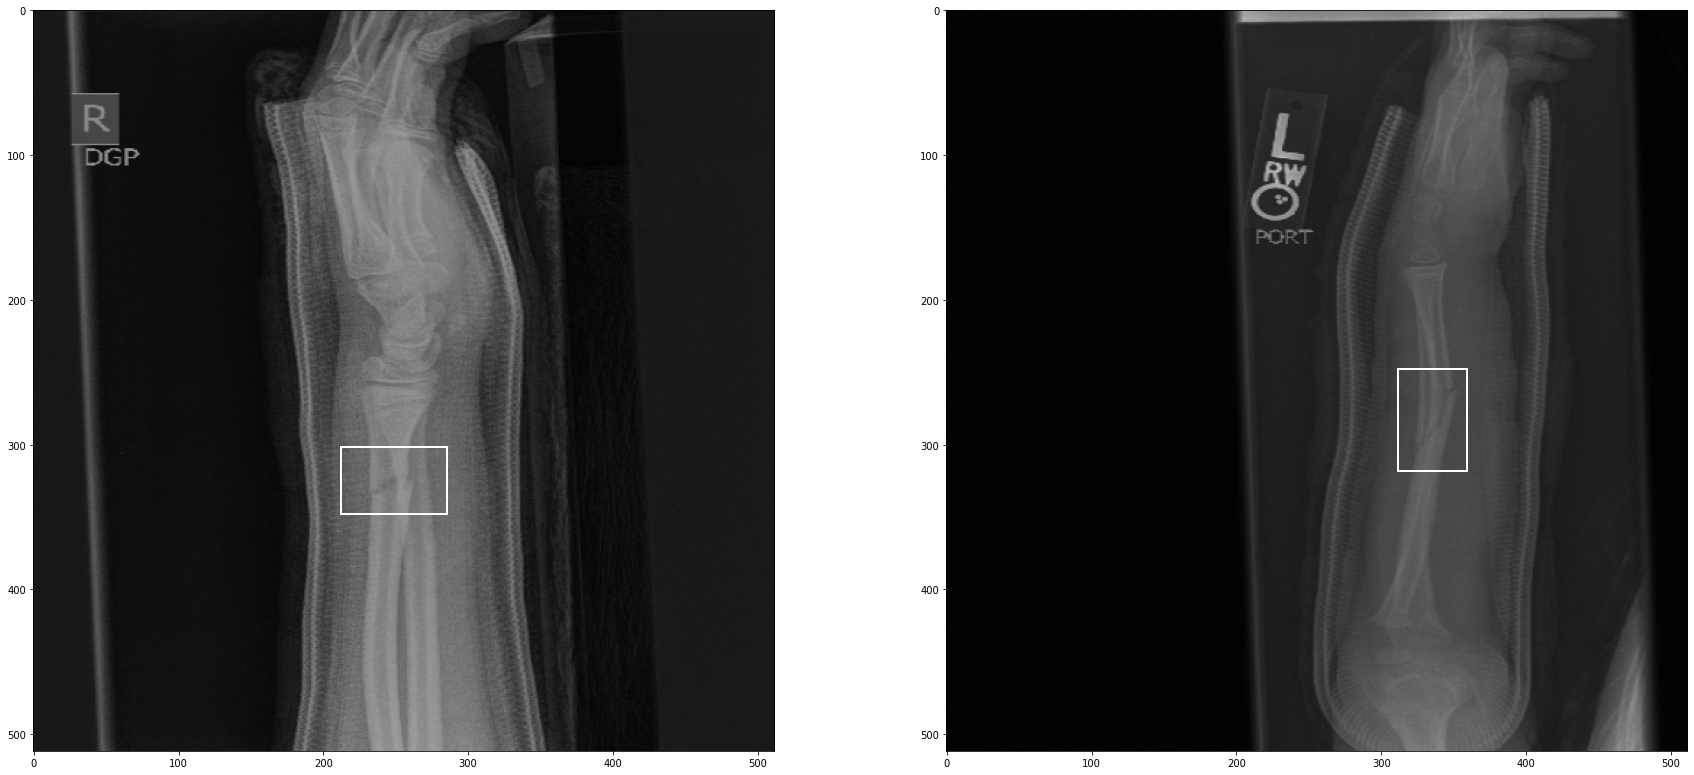

In [ ]:
view(images,targets,2) # truth

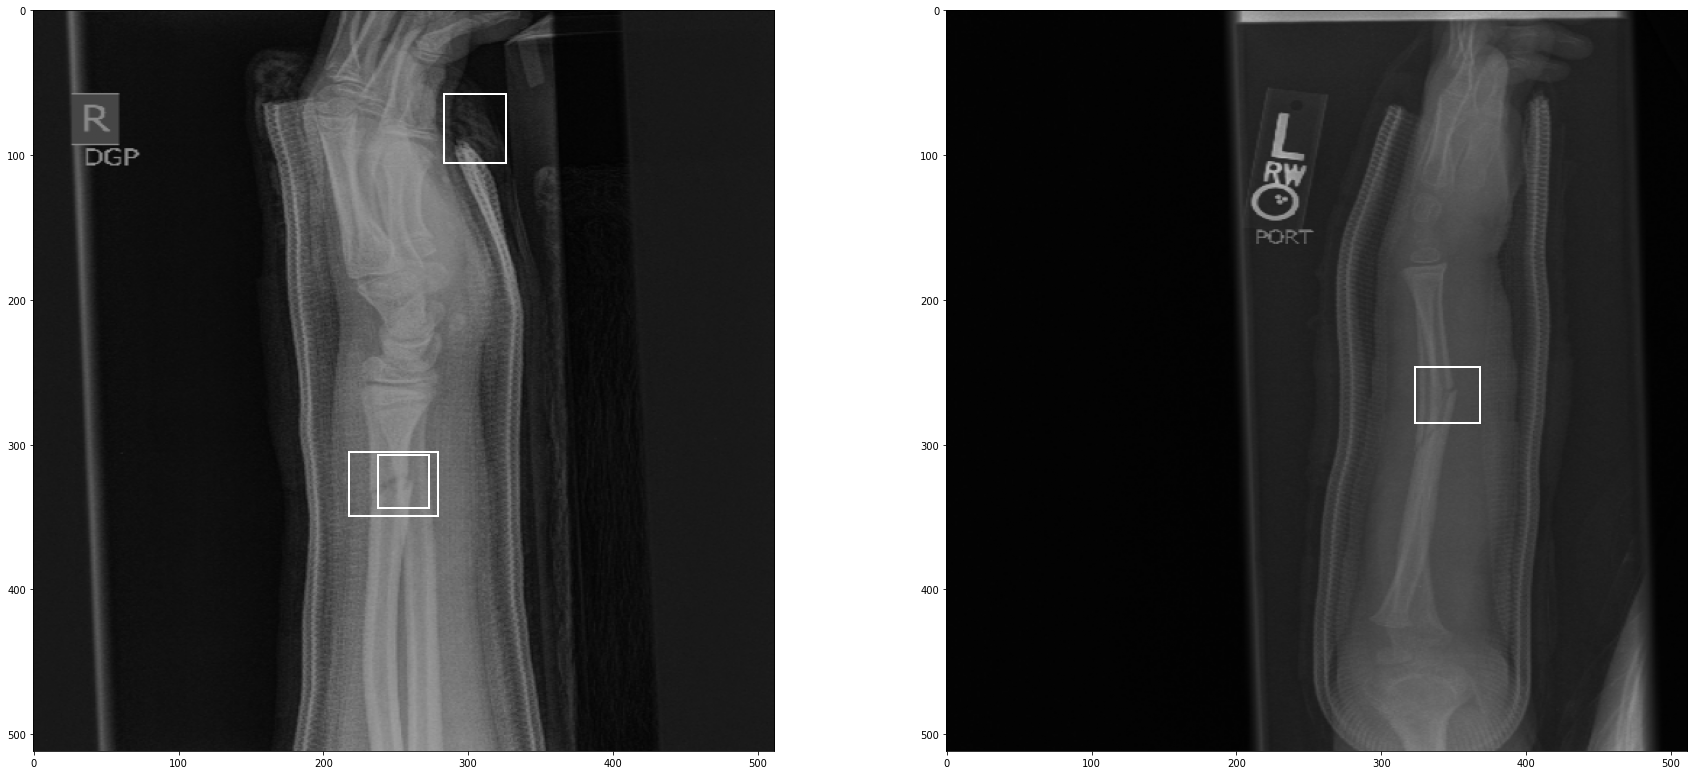

In [ ]:
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model.eval()
model=model.double()
output=model(images)
# predict :))
with torch.no_grad():
    view(images,output,2)